In [2]:
%matplotlib inline

import os
from matplotlib.pyplot import *
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
from astropy import units, constants as const
from astropy.visualization import quantity_support
from pyuvdata import UVData, UVBeam
from simpleDS import DelaySpectrum, cosmo as simple_cosmo, utils
from simpleDS.data import DATA_PATH
from pyuvdata.data import DATA_PATH as UVDATA_PATH
# Quantity Support makes plotting with quantities WAY easier.
quantity_support();

In [3]:
data_file = os.path.join(UVDATA_PATH, 'test_redundant_array.uvh5')
noise_file = os.path.join(DATA_PATH, 'test_redundant_noise_data.uvh5')
beam_file = os.path.join(DATA_PATH, 'test_redundant_array.beamfits')

In [4]:
# Read in the UVData object
uvd = UVData()
uvd.read_uvh5(data_file)
# It would normally be necessary to also down-select to only one
# set of redundant baselines but this PAPER data is already
# in that format.

In [5]:
# This will only take 31 times out of the file, makes it 
# easier on a personal laptop.
# uvd.select(times=np.unique(uvd.time_array)[300:330])

In [6]:
# Generate the UVBeam object and read the input file
uvb = UVBeam()
uvb.read_beamfits(beam_file)

In [7]:
# Initialize the delay specturm with the optional inputs
# uv (Input UVData object)
# uvb (Input UVBeam object)
# trcvr (Quantity in K of single receiver temperature or a (Nspws, Nfreqs) array of receiver temperature)
ds = DelaySpectrum(uv=uvd, uvb=uvb, trcvr=144 * units.K)

# all of these can also be set by calling the functions:
# ds.add_uvdata(uvd)
# ds.add_uvbeam(uvb)
# ds.add_trcvr(trcvr)

In [8]:
# The select spectral windows function allows us to 
# downselect to only a subset of the data and perform the Fourier Transform
# Must be a create an array with rectangular shape: (Nspws, Nfreqs)

# ds.select_spectral_windows([(0,8), (10, 18)])

# Don't be afraid to try new things:
# ds.select_spectral_windows([(0,2), (3,5), (6,8)])
# ds.select_spectral_windows([(0,9), (10, 19)])

# or use the frequencies directly
# new_freqs = units.Quantity([ds.freq_array[0,0:10], ds.freq_array[0,10:20]])
# ds.select_spectral_windows(freqs=new_freqs)

In [9]:
# The build in noise generator needs to get triggered to 
# generate better. It is a WIP but if you want a noise
# simulation along with your input make sure to call this function
ds.generate_noise()

In [10]:
# Calling `calculate_delay_spectrum` performs the FFT, cross-multiplication
# and renormalized to cosmological units.
# It also attempts to estimate the expected thermal noise level of the 
# output simulation
ds.calculate_delay_spectrum()

In [11]:
# the outputs can be a little daunting to deal with considering 
# the ds.power_array is an (Nspws, Npols, Nbls, Nbls, Ntimes, Ndelays) array.
# simpleDS was built to not care about your spectral windows or polarizations
# and can easily vectorize the computations over these axes.
# the result however is a bit of a confusing array shape.
# still lacking a get_power function, so indexing requires some user thought.

In [12]:
lsts = ds.lst_array*12./np.pi * units.h

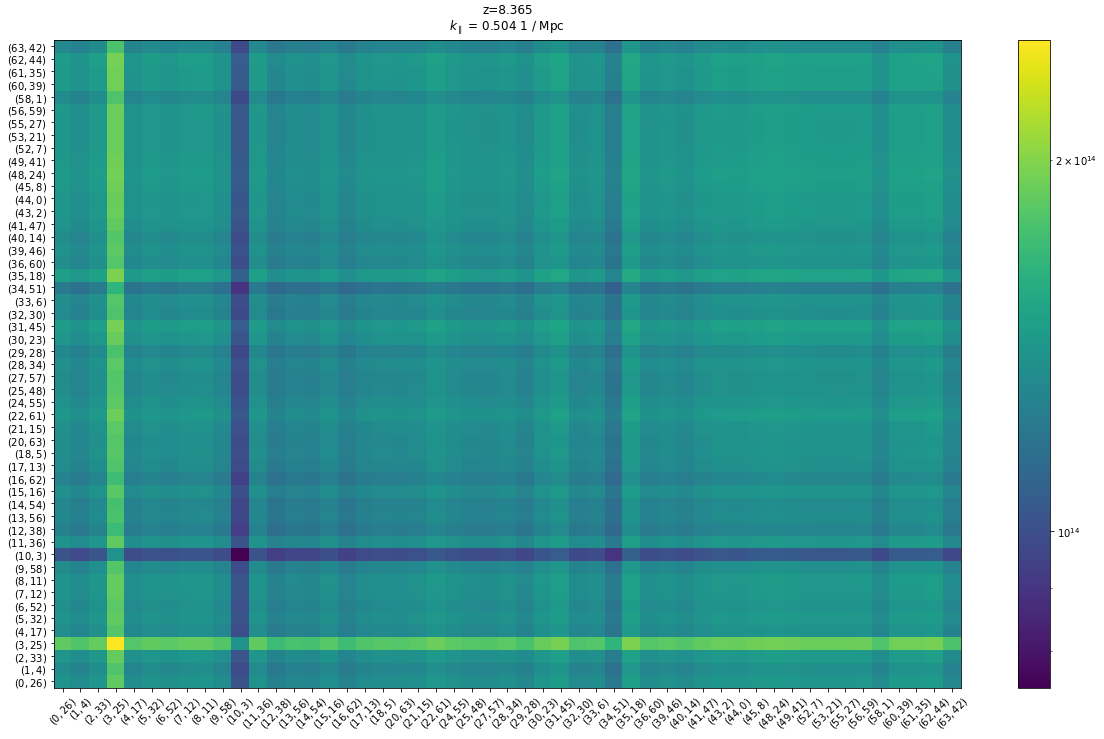

In [13]:
fig, ax = subplots(1, figsize=(17.5, 10))
# norm=LogNorm(vmin=1e13, vmax=1e15)
# for the 1st spectral window, on the 0th pol, plot all base cross-multiples (nbls, nbls), at the 0th time  and the 20th delay
# this is arbitrary but just want to highlight how to plot the Nbl x Nbl matrix of power for a given spectral window, polarization, time, and k-mode
im=ax.pcolormesh(np.abs(ds.power_array[(ds.Nspws-1)//2, 0, :, :, 0, (ds.Ndelays-1)//2]).value, norm=LogNorm()) 
fig.colorbar(im, ax=ax)

center_ticks = np.arange(ds.Nbls)+.5
ax.set_xticks(center_ticks)
bl_str = ['$({0},{1})$'.format(*uvd.baseline_to_antnums(bl)) for bl in ds.baseline_array ]
ax.set_xticklabels(bl_str, rotation=45);
ax.set_title("z={0:.3f}\n$k_{{\parallel}}$ = {1:.3f}".format(ds.redshift[(ds.Nspws-1)//2], ds.k_parallel[(ds.Nspws-1)//2, ds.Nfreqs-1]))
# ax.set_title("$k_{{\parallel}}$")

ax.set_yticks(center_ticks)
ax.set_yticklabels(bl_str);
fig.subplots_adjust(bottom=.05, top=.95, left=.05, right=.95)


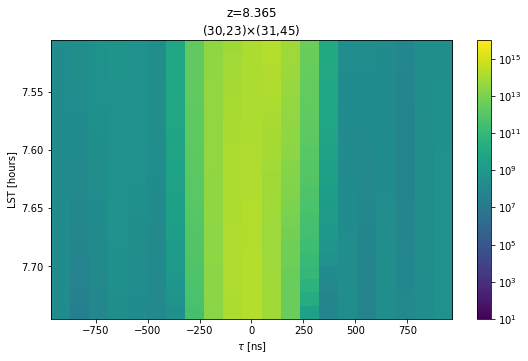

In [14]:
fig, ax = subplots(1, figsize=(9, 5))
norm=LogNorm(vmin=1e1, vmax=1e16)
# If we want to plot a waterfall of time versus delay for the cross multple of baseline number 27 * baseline number 28:
bl1, bl2 = ds.baseline_array[27], ds.baseline_array[28]
ants1 = uvd.baseline_to_antnums(bl1)
ants2 = uvd.baseline_to_antnums(bl2)
im=ax.pcolorfast(ds.delay_array.to('ns'), lsts, np.abs(ds.power_array[(ds.Nspws-1)//2, 0, 27, 28, :, :]).value, norm=norm)
fig.colorbar(im, ax=ax)
y_lim = [np.max(ax.get_ylim()), np.min(ax.get_ylim())]
ax.set_title("z={0:.3f}\n({1},{2})$\\times$({3},{4})".format(ds.redshift[(ds.Nspws-1)//2], ants1[0], ants1[1], ants2[0], ants2[1]))
ax.set_ylim(y_lim)
ax.set_xlabel("$\\tau$ [ns]")
ax.set_ylabel("LST [hours]")
fig.subplots_adjust(top=.9)

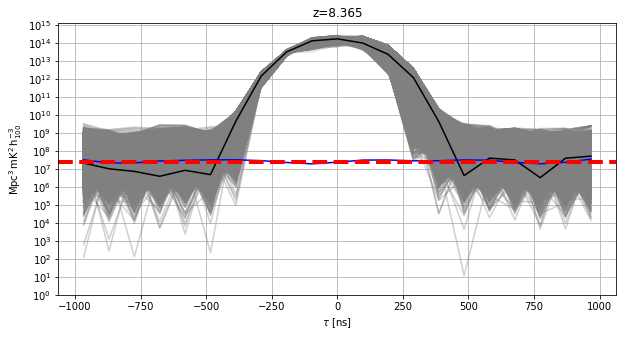

In [15]:
fig, ax = subplots(ncols=ds.Nspws, figsize=(10,5), squeeze=False, sharey=True)

# There's a lot of restructuring going on in these plots, but all it does is create an Nbls*Nbls*times, Ndelays array for each spectral window
# then plots each power spectrum in gray, the average over the first axis in black for the read file and blue for the noise simulation
# Plotted on top is the averaged thermal noise estimate in dashed red.
for cnt, _ax in enumerate(ax[0]):
    _ax.set_title("z={0:.3f}".format(ds.redshift[cnt]))
    _ax.plot(ds.delay_array, np.abs(ds.power_array[cnt,:,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,ds.Ndelays).T.real)/units.littleh**3, '', linestyle='-',color='grey', alpha=.2, mfc='none')
    _ax.plot(ds.delay_array, np.abs(ds.power_array[cnt,:,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,ds.Ndelays).mean(0).real)/units.littleh**3, '', linestyle='-',color='black', mfc='none')
    _ax.plot(ds.delay_array, np.abs(ds.noise_power[cnt,:,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,ds.Ndelays).mean(0).real)/units.littleh**3, '', linestyle='-',color='blue', mfc='none')
    _ax.axhline( ds.thermal_power[cnt,0,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,1).mean(0).real/units.littleh**3, linestyle='--', color='red', linewidth=4)
    
    # ax.plot(ds.delay_array, np.abs(ds.power_array[1,0,28,27,:].T.imag), '',linestyle='--')
    _ax.grid()
    _ax.set_yscale('log')
    _ax.set_xlabel("$\\tau$ [ns]")

y_lim = ax[0][0].get_ylim()
y_ticklabels = ["10^{0:d}".format(x) for x in np.arange(np.log10(y_lim[0]), np.log10(y_lim[1])+1, dtype=np.int)]
y_ticks = [10**x for x in np.arange(np.log10(y_lim[0]), np.log10(y_lim[1])+1, dtype=np.int)]
ax[0][0].set_yticks(y_ticks);

In [16]:
# Here i was curious and wanted to plot the output of what the System Temperature looks like
# SimpleDS uses the 180K@180MHz relation ship an assumes a spectral index of -2.55
# but it's fun to look at some times

thermal_noise_samples = utils.combine_nsamples(ds.nsample_array[:, 0], ds.nsample_array[:, 0],  axis=2)
lst_bins = (np.size(ds.lst_array) * np.diff(ds.lst_array)[0] * 12.
                    / np.pi * 3600 * units.s / ds.integration_time.to('s'))
npols_noise = np.array([2 if p in np.arange(1, 5) else 1
                        for p in ds.polarization_array])
npols_noise = npols_noise.reshape(1, 1, ds.Npols, 1, 1, 1)
Tsys = 180. * units.K * np.power(ds.freq_array / (.18 * units.GHz), -2.55)
Tsys += ds.trcvr.to('K')
Tsys = Tsys.reshape(ds.Nspws, 1, 1, 1, 1, ds.Nfreqs)


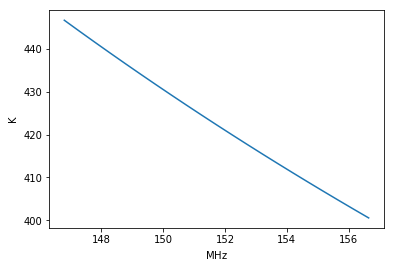

In [17]:
fig,ax =subplots(1)
for spw, freqs in enumerate(ds.freq_array):
    ax.plot(freqs.to('MHz'), Tsys[spw].squeeze().to('K'))